In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-embed-nn-model-rishi/jane_embed_nn_model_rishi.pt
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [3]:
import gc
import random
from   tqdm import tqdm
from   sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import psutil
import datatable as dt
from   collections import namedtuple
from   sklearn.pipeline import Pipeline
from   sklearn.impute import SimpleImputer
from   sklearn.preprocessing import StandardScaler

import os
import seaborn as sns
from   sklearn.utils import shuffle
import datetime
import time
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from   torch.autograd import Variable
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import TrainingArguments
from   transformers import AdamW, BertConfig
from   transformers import get_linear_schedule_with_warmup

In [4]:
DEVICE = torch.device ("cuda:0") if torch.cuda.is_available () else torch.device ("cpu")

In [5]:
dtype = {
    'date'      : 'int64', 
    'weight'    : 'float64',
    'resp'      : 'float64',
    'ts_id'     : 'int64',  
    'feature_0' : 'float64'
}
for i in range (1, 130):
    k = 'feature_' + str (i)
    dtype[k] = 'float32'
    
X = pd.read_csv ('../input/jane-street-market-prediction/train.csv', dtype=dtype)
f_columns = [c for c in X.columns if "feature" in c]
y = (X['resp'] > 0).astype ('int8')
X.drop (columns=['weight', 'resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'date', 'ts_id'], inplace=True)
preprocess_pipe =  Pipeline ([
    ("imputer", SimpleImputer (missing_values=np.nan, strategy='mean')),
    ("stand",   StandardScaler())
])
X = preprocess_pipe.fit_transform (X)

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.1)
del X, y
gc.collect ()
X_train

array([[-1.00988744,  0.43728856,  0.24038638, ...,  0.23414539,
         1.23419019,  0.0977841 ],
       [ 0.99020936, -0.92739749, -0.79304729, ...,  0.49266188,
        -1.11005897,  0.51576229],
       [-1.00988744, -0.37624849, -0.55731561, ...,  0.36661439,
         0.72965781,  0.36896382],
       ...,
       [ 0.99020936, -1.05881427, -0.91818339, ...,  0.25452235,
        -1.08564502, -0.05625339],
       [ 0.99020936, -0.02537408, -0.44806587, ..., -0.915584  ,
         0.59793358, -0.88419302],
       [-1.00988744, -0.10199829, -0.60691431, ...,  0.13324753,
         0.85724822,  0.40967746]])

In [6]:
dtype = {
    'feature'  : 'str', 
    'tag_0'    : 'int8'
}
for i in range (1, 29):
    k = 'tag_' + str (i)
    dtype[k] = 'int8'

In [7]:
features_df = pd.read_csv ('../input/jane-street-market-prediction/features.csv', usecols=range(1,30), dtype=dtype)
N_FEATURES  = features_df.shape[0]  # the features.csv has 130 features (1st row) = no of features in train.csv (feature_0 to feature_129)
N_FEAT_TAGS = features_df.shape[1]  # the features.csv has 29 tags
features_df.head ()

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
del features_df
gc.collect ()

20

In [9]:
N_FEATURES, N_FEAT_TAGS

(130, 29)

# Custom Trainer

In [10]:
# Utilities for my custom trainer

def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

def compute_metrics (labels, pred_logits):
    
    preds   = pred_logits.argmax (-1)             #;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    softmax = nn.Softmax (dim=1)
    pred_pr = softmax (torch.tensor (pred_logits))
    auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        'auc'      : auc
    }
    return metrics

In [11]:
class MyTrainer:
    
    def __init__(self, model, args, train_dataset, eval_dataset, compute_metrics=compute_metrics):
        
        self.model           = model
        self.args            = args
        self.train_dataset   = train_dataset
        self.eval_dataset    = eval_dataset
        self.compute_metrics = compute_metrics
        self.isTrained       = False
        self.device          = self.get_device_type ()
        
        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW (model.parameters (),
                           lr  = args.learning_rate,
                           eps = args.adam_epsilon # args.adam_epsilon  - default is 1e-8 is “a very small number to prevent any division by zero"
        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        self.epochs = self.args.num_train_epochs
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps = self.get_dataLoaders ()        
        return
    
    def get_device_type (self):
        
        # If there's a GPU available...
        if torch.cuda.is_available ():    

            # Tell PyTorch to use the GPU.    
            device = torch.device ("cuda")
            print('There are %d GPU(s) available.' % torch.cuda.device_count ())
            print('We will use the GPU:', torch.cuda.get_device_name (0))
        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device ("cpu")
        return device
    
    def get_dataLoaders (self):        
        
        # Create the DataLoaders for our training and validation sets.
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = RandomSampler (self.train_dataset)           # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = self.args.per_device_train_batch_size,
                    num_workers = 8    # TODO: uncomment this
        )
        train_dataloader  = DataLoader (self.train_dataset, batch_size=self.args.per_device_train_batch_size) # TODO: comment this
        validation_dataloader = None
        if self.eval_dataset:
            
            # For validation the order doesn't matter, so we'll just read them sequentially.
            validation_dataloader = DataLoader (
                        self.eval_dataset,             # The validation/dev samples.
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = self.args.per_device_eval_batch_size,
                        num_workers = 8    # TODO: uncomment this
            )
            validation_dataloader  = DataLoader (self.eval_dataset, batch_size=self.args.per_device_eval_batch_size) # TODO: comment this
            
        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        num_training_steps = len (train_dataloader) * self.epochs

        # Create the learning rate scheduler.
        lr_scheduler = get_linear_schedule_with_warmup (self.optimizer, 
                                                        num_warmup_steps   = self.args.warmup_steps, # Default value in run_glue.py
                                                        num_training_steps = num_training_steps)
        return train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
    
    
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    
    def train (self):
        
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
        
        # Set the seed value all over the place to make this reproducible.
        seed_val = 42
        random.seed (seed_val)
        np.random.seed (seed_val)
        torch.manual_seed (seed_val)
        torch.cuda.manual_seed_all (seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []
        # Measure the total training time for the whole run.
        total_t0 = time.time ()
        # inint min_val_loss to a large val, if after each epoch eval-loss < min_val_loss, then save the model
        min_val_loss   = 9999
        min_train_loss = 9999
        step = 0
        
        # For each epoch...
        for epoch_i in range (0, self.epochs):

            # ========================================
            #               Training
            # ========================================

            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time ()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.model.train ()

            # For each batch of training data...
            for stp, batch in enumerate (self.train_dataloader):

                step += 1
                # Progress update every 40 batches.
                # print ('batch =', batch)
                if step % 50 == 0 and not step == 0:
                    
                    # Calculate elapsed time in minutes.
                    elapsed = format_time (time.time() - t0)
                    # Report progress.
                    print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len (self.train_dataloader), elapsed))
                if (self.args.max_steps > 0 and self.args.max_steps < step) or  \
                   (self.args.eval_steps> 0 and step % self.args.eval_steps==0 and step>0):
                    
                    avg_train_loss = total_train_loss / step
                    training_time = format_time (time.time () - t0)
                    if self.validation_dataloader:
                        
                        print ("Running Validation...")
                        avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
                        training_stats.append ({
                                'epoch'         : epoch_i + 1,
                                'training_loss' : avg_train_loss,
                                'eval_loss'     : avg_val_loss,
                                'eval_f1'       : avg_val_f1,
                                'eval_mcc'      : avg_val_mcc, 
                                'eval_precision': avg_val_precision,
                                'eval_recall'   : avg_val_recall,
                                'eval_auc'      : avg_val_auc, 
                                'eval_accuracy' : avg_val_accuracy,
                                'training_time' : training_time,
                                'eval_time'     : validation_time                   
                        })
                        # save this model if the eval loss decreases from the minimum so far
                        if avg_val_loss < min_val_loss: 

                            min_val_loss = avg_val_loss
                            torch.save (model.state_dict (), "jane_embed_nn_model_rishi.pt")     # TODO: uncomment this
                    
                    if self.args.max_steps > 0 and self.args.max_steps < step :
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        self.plot_train_stats_regression (training_stats)
                        return training_stats
                    
                self.model.zero_grad ()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                # loss, logits = self.model (b_inputs, .., labels=b_labels)
                # print ('batch: \n', batch)
                # for k in batch:
                #     batch[k] = batch[k].to (self.device)
                batch['features'] = batch['features'].to (self.device).float ()
                if 'labels' in  batch:
                    batch['labels'] = batch['labels'].to (self.device).long ()
                output    = self.model (**batch)
                loss      = output.loss
                logits    = output.logits
                
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item ()
                # Perform a backward pass to calculate the gradients.
                loss.backward ()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step ()
                # Update the learning rate.
                self.lr_scheduler.step ()
            # At the end of each epoch measure stats and eval:
            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len (self.train_dataloader)
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.2f}".format (avg_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))
            
            if self.validation_dataloader:
                
                print ("\n  Running Validation...")
                avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
                # Record all statistics from this epoch.
                training_stats.append ({
                        'epoch'         : epoch_i + 1,
                        'training_loss' : avg_train_loss,
                        'eval_loss'     : avg_val_loss,
                        'eval_f1'       : avg_val_f1,
                        'eval_mcc'      : avg_val_mcc, 
                        'eval_precision': avg_val_precision,
                        'eval_recall'   : avg_val_recall,
                        'eval_auc'      : avg_val_auc, 
                        'eval_accuracy' : avg_val_accuracy,
                        'training_time' : training_time,
                        'eval_time'     : validation_time                   
                })
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < min_val_loss:
                    
                    min_val_loss = avg_val_loss
                    torch.save (model.state_dict (), "jane_embed_nn_model_rishi.pt")     # TODO: uncomment this
            else:
                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < min_train_loss: 
                    
                    min_train_loss = avg_train_loss
                    torch.save (model.state_dict (), "jane_embed_nn_model_rishi.pt")     # TODO: uncomment this
        print ("")
        print ("Training complete!")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.plot_train_stats (training_stats)
        return training_stats
    
    def evaluate (self):
        
        t0 = time.time ()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_auc       = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                # Forward pass, calculate logit predictions.
                # for k in batch:
                #     batch[k] = batch[k].to (self.device)
                batch['features'] = batch['features'].to (self.device).float ()
                batch['labels'] = batch['labels'].to (self.device).long ()
                output    = self.model (**batch)
                loss      = output.loss
                logits    = output.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item ()
            # Move logits and labels to CPU
            logits    = logits.detach ().cpu ().numpy ()
            label_ids = batch['labels'].detach ().cpu ().numpy ()            

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            metrics = self.compute_metrics (label_ids, logits)
            total_eval_mcc       += metrics['mcc']
            total_eval_f1        += metrics['f1']
            total_eval_precision += metrics['precision']
            total_eval_recall    += metrics['recall']
            total_eval_auc       += metrics['auc']
            total_eval_accuracy  += metrics['accuracy']

        # Report the final accuracy for this validation run.
        avg_val_f1 = total_eval_f1 / len (self.validation_dataloader)
        print ("  F1: {0:.3f}".format (avg_val_f1))
        avg_val_mcc = total_eval_mcc / len (self.validation_dataloader)
        print ("  MCC: {0:.3f}".format (avg_val_mcc))
        avg_val_precision = total_eval_precision / len (self.validation_dataloader)
        print ("  Precision: {0:.3f}".format (avg_val_precision))
        avg_val_recall = total_eval_recall / len (self.validation_dataloader)
        print ("  Recall: {0:.3f}".format (avg_val_recall))
        avg_val_auc = total_eval_auc / len (self.validation_dataloader)
        print ("  AUC: {0:.3f}".format (avg_val_auc))
        avg_val_accuracy = total_eval_accuracy / len (self.validation_dataloader)
        print ("  Accuracy: {0:.3f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        print ("  Validation Loss: {0:.2f}".format (avg_val_loss))
        print ("  Validation took: {:}".format (validation_time))            
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        mccs   = accuracies = f1_scores = precisions = recalls = auc = losses = epochs = -1
        epochs = training_stats[-1]['epoch']
        if 'eval_mcc' in training_stats[0]:
            mccs       = [e['eval_mcc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_f1' in training_stats[0]:
            f1_scores  = [e['eval_f1'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        if 'eval_precision' in training_stats[0]:
            precisions = [e['eval_precision'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        if 'eval_recall' in training_stats[0]:
            recalls    = [e['eval_recall'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        if 'eval_auc' in training_stats[0]:
            auc        = [e['eval_auc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_auc')
        if 'eval_loss' in training_stats[0]:
            losses     = [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('mccs       :', mccs)
        print ('accuracies :', accuracies)
        print ('precisions :', precisions)
        print ('recalls    :', recalls)
        print ('f1_scores  :', f1_scores)
        print ('auc        :', auc)
        print ('losses     :', losses)
        print ('tr_losses  :', tr_losses)
        return
    
    
    def getTrainedModel (self):
        
        if self.isTrained:
            return self.model
        return None
    
    
    def predict (self, prediction_dataset, isRemoveLabels=True):
        """
        return: pred_logits, true_labels, metrics (if true 'labels' are input in the prediction_dataset)
        """     
        
        prediction_sampler    = SequentialSampler (prediction_dataset)
        prediction_dataloader = DataLoader (prediction_dataset, sampler=prediction_sampler, batch_size=self.args.per_device_eval_batch_size)
        print ('Predicting labels for {:,} test sentences...'.format (len (prediction_dataset)))
        
        # Put model in evaluation mode
        self.model.eval ()

        # Tracking variables 
        predictions = []
        # true_labels = []
        
        # Predict 
        for batch in prediction_dataloader:
            
            if 'labels' in batch and isRemoveLabels:
                batch.pop ('labels')
            # Add batch to GPU
            # batch = {t:batch[t].to (self.device) for t in batch}
            batch['features'] = batch['features'].to (self.device).float ()
            if 'labels' in  batch:
                batch['labels'] = batch['labels'].to (self.device).long ()

            # Unpack the inputs from our dataloader
            # b_input_ids, b_input_mask, b_segment_ids = batch

            # Telling the model not to compute or store gradients, saving memory and 
            # speeding up prediction
            with torch.no_grad ():
                # Forward pass, calculate logit predictions
                outputs = model (**batch)
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach ().cpu ().numpy ()
            # label_ids = b_labels.to ('cpu').numpy ()

            # Store predictions and true labels
            predictions.append (logits)
            # true_labels.append (label_ids)
            print ('Done predictions for ', len(predictions), '/', len(prediction_dataloader), 'batches')
        print ('Done prediction')
        
        # Combine the results across all batches to get the predicted logits
        pred_logits = np.concatenate (predictions, axis=0)
        # For each sample, pick the label (0,1,2) with the highest score.
        # pred_labels = np.argmax (pred_logits, axis=1).flatten()
        # returns the predicted logits
        return pred_logits, None, None

# Create Datasets

In [12]:
# create a custom map type dataset
class JaneDataset (torch.utils.data.Dataset):
    
    def __init__(self, df, labels=None):
        
        if isinstance (df, pd.DataFrame):
            df.reset_index (drop=True, inplace=True)
        if isinstance (labels, pd.Series):
            labels.reset_index (drop=True, inplace=True)
        self.df     = df
        self.labels = labels 
        return
    
    def __len__(self):
        return len (self.df)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor (idx):
            idx = idx.tolist ()
        
        # date    = self.df['date'][idx]
        # weight  = self.df['weight'][idx]
        # ts_id   = self.df['ts_id'][idx]
        # f_columns = ['feature_' + str(i) for i in range (N_FEATURES)]
        
        sample   = None
        if isinstance (self.df, pd.DataFrame):
            features = np.array (self.df.loc[idx, f_columns])
        else:
            features = self.df[idx]
            
        if self.labels is not None:
            sample = {'features': features, 'labels': self.labels[idx]}
        else:
            sample = {'features': features}
        return sample

In [13]:
train_dataset = JaneDataset (X_train, y_train)
eval_dataset  = JaneDataset (X_test,  y_test)
train_dataset[1]  # ['features'].shape                         # output    = self.model (date, weight, ts_id, features, target)

{'features': array([ 0.99020936, -0.92739749, -0.79304729,  0.63938174,  1.09422777,
         0.03739973,  0.07354305,  0.12458087,  0.34855278, -0.34955536,
         0.06692272, -0.336642  , -0.32440624, -0.73268682, -0.68484988,
        -0.29886931,  0.11822028,  0.21301071,  0.48877323,  0.15460674,
         0.5380946 ,  0.19728011,  0.35747304,  0.28794668,  0.68569282,
         0.38080853,  0.89231615, -0.47243553, -0.69614776, -0.33464426,
        -0.40303161, -0.55590007, -0.83352502, -0.25838753, -0.33302043,
        -0.2642851 , -0.35775387,  0.66884474,  1.15964351, -0.14144787,
        -0.21785851,  0.21430204, -1.49806786, -0.8508794 , -0.10149459,
         0.50069547, -0.2252556 , -0.64997216, -0.36749891, -0.20698133,
         0.29629526,  0.11000451,  1.00987712, -1.08607524,  0.16454727,
        -0.31578111, -0.0980276 , -0.36937024, -0.35565366, -0.18460732,
        -0.98305537, -0.96463881,  3.20176925,  3.178548  ,  1.93680844,
         2.70529638,  2.64772254, -0.72

# Model

In [14]:
class FFN (nn.Module):
    
    def __init__(self, state_size=200):
        
        super (FFN, self).__init__()
        self.state_size = state_size
        self.lr1        = nn.Linear (state_size, state_size)
        self.relu       = nn.ReLU ()
        self.lr2        = nn.Linear (state_size, state_size)
        self.dropout    = nn.Dropout (0.2)
    
    def forward (self, x):
        
        x = self.lr1 (x)
        x = self.relu (x)
        x = self.lr2 (x)
        x = self.relu (x)
        return self.dropout (x)

In [36]:
class Clf_Model (nn.Module):
    
    def __init__(self, embed_dim=N_FEAT_TAGS*2, csv_file='../input/jane-street-market-prediction/features.csv'):
        
        super (Clf_Model, self).__init__()
        global N_FEAT_TAGS
        N_FEAT_TAGS = 29
        
        # store the features to tags mapping as a datframe tdf, feature_i mapping is in tdf[i, :]
        dtype = {'tag_0' : 'int8'}
        for i in range (1, 29):
            k = 'tag_' + str (i)
            dtype[k] = 'int8'
        t_df = pd.read_csv (csv_file, usecols=range (1,N_FEAT_TAGS+1), dtype=dtype)
        # add a new tag in which only feature_0=1 and all other=0 since feature_0=0 for all the prev tags
        t_df['tag_29'] = np.array ([1] + ([0] * (t_df.shape[0]-1)) ).astype ('int8')
        self.features_tag_matrix = torch.tensor (t_df.to_numpy ())
        N_FEAT_TAGS += 1
        
        # print ('self.features_tag_matrix =', self.features_tag_matrix)
        
        # embeddings for the tags. Each feature is taken a an embedding which is an avg. of its' tag embeddings
        self.embed_dim     = embed_dim
        self.tag_embedding = nn.Embedding (N_FEAT_TAGS+1, embed_dim) # create a special tag if not known tag for any feature
        self.tag_weights   = nn.Linear (N_FEAT_TAGS, 1)
        
        self.dropout      = nn.Dropout (0.2)
        self.layer_normal = nn.LayerNorm (embed_dim) 
        self.ffn          = FFN (embed_dim)
        self.outDense     = nn.Linear (embed_dim, 2)
        self.outActivtn   = nn.LogSoftmax (dim=1)
        self.criterion    = nn.NLLLoss ()
        return
    
    def features2emb (self):
        """
        idx : int feature index 0 to N_FEATURES-1 (129)
        """
        
        all_tag_idxs = torch.LongTensor (np.arange (N_FEAT_TAGS)).to (DEVICE)              # (30,)
        tag_bools    = self.features_tag_matrix                                # (130, 30)
        # print ('tag_bools.shape =', tag_bools.size())
        f_emb        = self.tag_embedding (all_tag_idxs).repeat (130, 1, 1)    #;print ('1. f_emb =', f_emb) # (30, 7) * (130, 1, 1) = (130, 30, 7)
        # print ('f_emb.shape =', f_emb.size())
        f_emb        = f_emb * tag_bools[:, :, None]                           #;print ('2. f_emb =', f_emb) # (130, 30, 7) * (130, 29, 1) = (130, 30, 7)
        # print ('f_emb.shape =', f_emb.size())
        
        # Take avg. of all the present tag's embeddings to get the embedding for a feature
        # s = torch.sum (tag_bools, dim=1)                                       # (130,)
        # print ('s =', s)              
        # f_emb = torch.sum (f_emb, dim=-2) / s[:, None]                         # (130, 7)
        # print ('f_emb =', f_emb)        
        # print ('f_emb.shape =', f_emb.shape)
        
        # take a linear combination of the present tag's embeddings
        f_emb = f_emb.permute (0, 2, 1)                                        # (130, 7, 30)
        f_emb = self.tag_weights (f_emb)                      #;print ('3. f_emb =', f_emb)                 # (130, 7, 1)
        f_emb = torch.squeeze (f_emb, dim=-1)                 #;print ('4. f_emb =', f_emb)                 # (130, 7)
        return f_emb
    
    def forward (self, features, labels=None):
        """
        when you call `model (x ,y, z, ...)` then this method is invoked
        """
        
        f_emb    = self.features2emb ()                                #;print ('5. f_emb =', f_emb); print ('6. features =', features) # (130, 7)
        # print ('features.shape =', features.shape, 'f_emb.shape =', f_emb.shape)
        features = torch.matmul (features, f_emb)                      #;print ('7. features =', features) # (1, 130) * (130, 7) = (1, 7)
        # print ('features.shape =', features.shape)
        
        x          = self.ffn (features)                               #;print ('8. x.shape = ', x.shape, 'x =', x) 
        x          = self.layer_normal (x + features)                  #;print ('9. x.shape = ', x.shape, 'x =', x) 
        out_logits = self.outDense (x)                                 #;print ('10. out_logits.shape = ', out_logits.shape, 'out_logits =', out_logits)
        # out_logits = torch.squeeze (out_logits, dim=-1)
        if labels is None:
            
            # return a named tuple
            Logits     = namedtuple ('Logits',['logits'])
            out_logits = Logits (out_logits)
            return out_logits                                          # you can access the value as out_logits.logits        
        
        log_ps     = self.outActivtn (out_logits)                      # ;print('labels.size=', labels.size(), 'log_ps.size=', log_ps.size())
        # calculate loss, this is used for back propagation later
        batchLoss  = self.criterion (log_ps, labels)
        
        # return a named tuple
        Loss_Logits = namedtuple ('Loss_Logits',['loss','logits'])
        loss_logits = Loss_Logits (batchLoss, out_logits)              # you can access the value as out_logits.loss, out_logits.logits
        #print ('11. out_logits =', out_logits)
        return loss_logits

In [37]:
model = Clf_Model ()

# This code version 1 broke after training, hence reloading that model here.
# try:
#     model.load_state_dict (torch.load ("../input/jane-embed-nn-model-rishi/jane_embed_nn_model_rishi.pt"))
# except:
#     model.load_state_dict (torch.load ("../input/jane-embed-nn-model-rishi/jane_embed_nn_model_rishi.pt", map_location='cpu'))
model = model.float ()

In [38]:
training_args = TrainingArguments (

    output_dir      = './results',     # output directory
    num_train_epochs= 5,               # for training from scratch
    warmup_steps    = 10,              # for lr scheduling
    eval_steps      = 100,             # Number of update steps between two evaluations, if <=0 then eval at end of each epoch
    max_steps       = 0,               # If set to a positive number, the total number of training steps to perform. Overrides num_train_epochs
    learning_rate   = 5e-4,            # Actually = 1e-2 for training from scratch, without using the jane_embed_nn_model_rishi.pt
    # adam_epsilon  = 1e-8             # - default is 1e-8 is “a very small number to prevent any division by zero"
    per_device_train_batch_size= 50000, # batch size per device during training
    per_device_eval_batch_size = 50000, # batch size for evaluation
)
trainer = MyTrainer (
    
    model         = model,           # the instantiated 🤗 Transformers model to be trained
    args          = training_args,   # training arguments, defined above
    train_dataset = train_dataset,   # training dataset
    eval_dataset  = eval_dataset,    # evaluation dataset
)

No GPU available, using the CPU instead.


In [40]:
# uncomment this to train from scratch
trainer.train ()

In [19]:
# uncomment this to train from scratch
# Load the best model so far
del model
gc.collect ()
model = Clf_Model ()
try:
    model.load_state_dict (torch.load ("jane_embed_nn_model_rishi.pt"))
except:
    model.load_state_dict (torch.load ("jane_embed_nn_model_rishi.pt", map_location='cpu'))
model = model.float ()

In [20]:
training_args = TrainingArguments (

    output_dir      = './results',     # output directory
    num_train_epochs= 2,               # for training from scratch
    warmup_steps    = 5,               # for lr scheduling
    eval_steps      = 20,              # Number of update steps between two evaluations, if <=0 then eval at end of each epoch
    max_steps       = 0,               # If set to a positive number, the total number of training steps to perform. Overrides num_train_epochs
    learning_rate   = 5e-5,            # Actually = 1e-2 for training from scratch, without using the jane_embed_nn_model_rishi.pt
    # adam_epsilon  = 1e-8             # - default is 1e-8 is “a very small number to prevent any division by zero"
    per_device_train_batch_size= 50000, # batch size per device during training
    per_device_eval_batch_size = 50000, # batch size for evaluation
)
trainer = MyTrainer (
    
    model         = model,           # the instantiated 🤗 Transformers model to be trained
    args          = training_args,   # training arguments, defined above
    train_dataset = eval_dataset,    # training dataset
    eval_dataset  = None,            # evaluation dataset
)

No GPU available, using the CPU instead.



======== Epoch 1 / 2 ========
Training...
  Average training loss: 0.69
  Training epcoh took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Average training loss: 0.69
  Training epcoh took: 0:00:03

Training complete!
Total training took 0:00:06 (h:mm:ss)


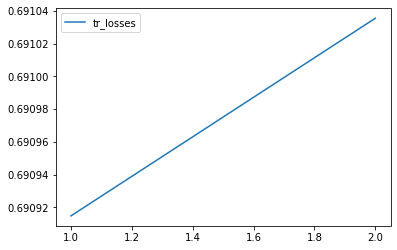

mccs       : -1
accuracies : -1
precisions : -1
recalls    : -1
f1_scores  : -1
auc        : -1
losses     : -1
tr_losses  : [0.6909147500991821, 0.6910355448722839]


[{'epoch': 1, 'training_loss': 0.6909147500991821, 'training_time': '0:00:03'},
 {'epoch': 2, 'training_loss': 0.6910355448722839, 'training_time': '0:00:03'}]

In [21]:
# uncomment this to train from scratch
trainer.train ()

# Test

In [22]:
import janestreet
env      = janestreet.make_env() # initialize the environment
env_iter = env.iter_test() # an iterator which loops over the test set

# For direct submission, without using the Trainer class

In [23]:
for test_df, pred_df in env_iter:
    if test_df["weight"].item () > 0:
        
        test_df.drop (columns=['weight', 'date'], inplace=True)
        test_df.reset_index (drop=True, inplace=True)
        test_df = preprocess_pipe.transform (test_df)        
        test_dataset = JaneDataset (test_df)
        pred = []
        for i in range (len (test_dataset)):
            
            batch = test_dataset[i]
            # Add batch to GPU
            for k in batch:
                batch[k] = torch.tensor (batch[k]).to (DEVICE).float ()
            pred_logits  = model (**batch).logits.detach ().cpu ().numpy ()
            pred.append (pred_logits)
        
        pred_logits    = np.concatenate (pred, axis=0).reshape ((-1, 2))
        pred_labels    = np.argmax (pred_logits, axis=1).flatten ()
        pred_df.action = pred_labels.astype (int)
    else:
        pred_df.action = 0
        
    # print (pred_df)
    # print ("--------------")
    env.predict (pred_df)

In [24]:
print ('Done !')

Done !
